# ESiWACE3 Compression Lab in WebAssembly

**Note:** Any changes you make to this notebook will be lost once the page is closed or refreshed. Please download any files you would like to keep.

**Note:** The WASM-based version of the compression lab running inside JupyterLite has only been tested in recent Chrome and Firefox browsers.

## Patch HTTP requests for Pyodide kernels in JupyterLite

In [1]:
import pyodide_http
pyodide_http.patch_all()

## Fetch an example dataset

### (a) Download a small dataset into memory

Small datasets can be downloaded and saved in the in-memory file system of this JupyterLite notebook. Note, however, that memory is limited.

In [2]:
import urllib.request
import shutil
from pathlib import Path

small_path = Path("hplp_ml_q_dx=2.0.grib")

with urllib.request.urlopen(
    "https://juntyr.github.io/field-compression-lite/files/hplp_ml_q_dx=2.0.grib"
) as response:
    with open(small_path, "wb") as file:
        shutil.copyfileobj(response, file)

small_path

PosixPath('hplp_ml_q_dx=2.0.grib')

### (b) Mount a large dataset from the user's filesystem

Alternatively, you can also upload a GRIB file from your own computer. The file is mounted in read-only mode into the notebook's file system without reading the file into memory, thus allowing arbitrarily large files to be made accessible. It is worth remembering that large files can still only be read if the algorithm that processes them supports streaming or chunking and does not request to load all data into memory at the same time.

If this notebook is run inside JupyterLite, the file also never leaves your own computer.

Note that this code is commented out since it requires your user input to upload a file and progress through the code. To mount an uploaded file, uncomment the following code cell and run it.

In [3]:
# import ipyfilite

# uploader = ipyfilite.FileUploadLite()
# await uploader.request()
# uploader.close()

# upload_path = uploader.value[0].path if len(uploader.value) > 0 else None
# upload_path

Once you have selected a file to upload, you can retrieve the path at which the file is now mounted in read-only mode.

### (c) Mount a large dataset from a URL that supports HTTP Range Requests

Similarly, you can also mount a file from a URL. The file is mounted in read-only mode into the notebook's file system without reading the file into memory, thus allowing arbitrarily large files to be made accessible. Note that the HTTP endpoint at the URL must support [range requests](https://developer.mozilla.org/en-US/docs/Web/HTTP/Range_requests) so that only small chunks of the file are loaded upon request. It is also worth remembering that large files can still only be read if the algorithm that processes them supports streaming or chunking and does not request to load all data into memory at the same time.

In [4]:
import ipyfilite

http_path = ipyfilite.HTTPFileIO(
    name="hplp_ml_q_dx=2.0.grib", url="https://juntyr.github.io/field-compression-lite/files/hplp_ml_q_dx=2.0.grib",
).path
http_path

PosixPath('/http/fd39aba4-e61c-4256-b14f-ab0cf013dfb8/hplp_ml_q_dx=2.0.grib')

## Load the example dataset into `xarray`

In [5]:
import fcpy
import xarray as xr

To select which dataset you wish to load, only execute one of the following three lines:

In [6]:
dataset_path = small_path
# dataset_path = upload_path
# dataset_path = http_path

Next, we load the dataset into `xarray`. While the
```python
xr.load_dataset(str(dataset_path))
```
function is generally sufficient to load the data, we specify some additional options for GRIB files, which are loaded with `cfgrib`.

In [7]:
if dataset_path.suffix == ".grib":
    ds = xr.load_dataset(str(dataset_path), engine="cfgrib", backend_kwargs=dict(indexpath=""))
else:
    ds = xr.load_dataset(str(dataset_path))

ds

<xarray.Dataset>
Dimensions:     (hybrid: 10, latitude: 91, longitude: 180)
Coordinates:
    time        datetime64[ns] 2020-07-21
    step        timedelta64[ns] 00:00:00
  * hybrid      (hybrid) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0
  * latitude    (latitude) float64 90.0 88.0 86.0 84.0 ... -86.0 -88.0 -90.0
  * longitude   (longitude) float64 0.0 2.0 4.0 6.0 ... 352.0 354.0 356.0 358.0
    valid_time  datetime64[ns] 2020-07-21
Data variables:
    q           (hybrid, latitude, longitude) float64 2.938e-06 ... 3.398e-06
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-06-09T17:41 GRIB to CDM+CF via cfgrib-0.9.1...

## Plot the loaded dataset

We first plot the loaded dataset. `fcpy` provides the
```python
fcpy.suite.plot_spatial_dataarray(
    da: xr.DataArray,
) -> Tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]
```
helper function to plot spatial data. Note that this function requires that the data array is gridded along the standard "latitude" and "longitude" axes.

/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


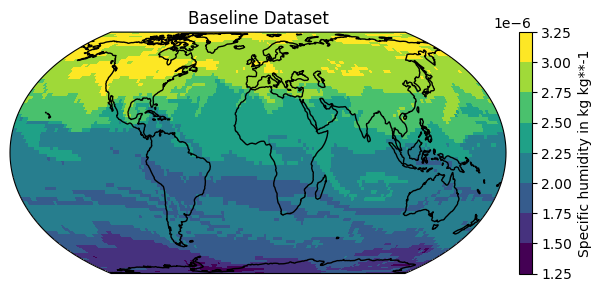

In [8]:
fig, ax = fcpy.suite.plot_spatial_dataarray(
    ds["q"].sel(dict(hybrid=1)),
)
ax.set_title("Baseline Dataset");

## Run a simple compressor

In [9]:
import numcodecs

simple_compressor = numcodecs.Quantize(digits=7, dtype="float64")
ds_simple = fcpy.suite.compress_decompress_dataset(ds, simple_compressor)

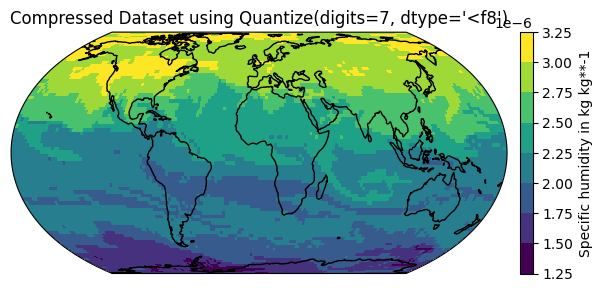

In [10]:
fig, ax = fcpy.suite.plot_spatial_dataarray(
    ds_simple["q"].sel(dict(hybrid=1)),
)
ax.set_title(f"Compressed Dataset using {simple_compressor}");

## Plot the simple compression error

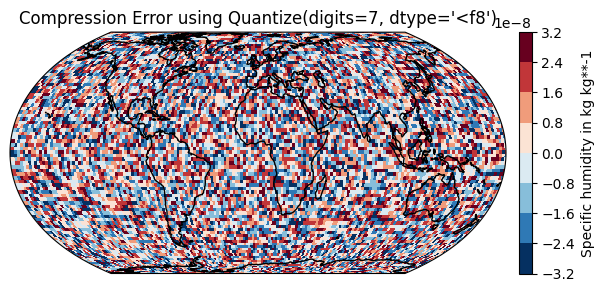

In [11]:
fig, ax = fcpy.suite.plot_spatial_dataarray(
    ds.copy(data=(ds_simple - ds))["q"].sel(dict(hybrid=1)),
)
ax.set_title(f"Compression Error using {simple_compressor}");

## Run a more complex compressor

In [12]:
import numcodecs

complex_compressor = numcodecs.ZFPY(tolerance=1e-8)
ds_complex = fcpy.suite.compress_decompress_dataset(ds, complex_compressor)

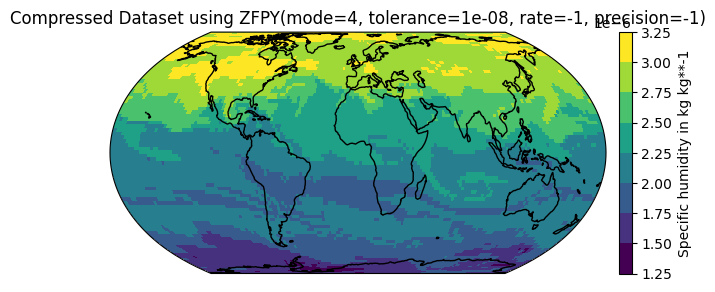

In [13]:
fig, ax = fcpy.suite.plot_spatial_dataarray(
    ds_complex["q"].sel(dict(hybrid=1)),
)
ax.set_title(f"Compressed Dataset using {complex_compressor}");

## Plot the simple compression error

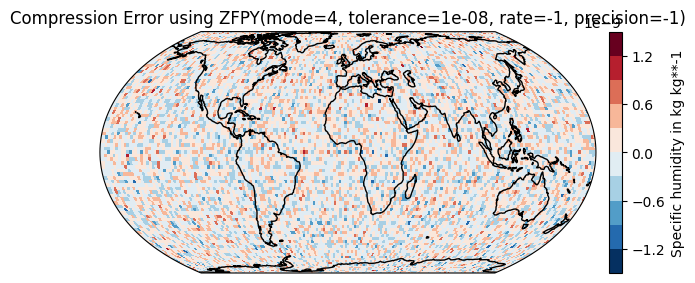

In [14]:
fig, ax = fcpy.suite.plot_spatial_dataarray(
    ds.copy(data=(ds_complex - ds))["q"].sel(dict(hybrid=1)),
)
ax.set_title(f"Compression Error using {complex_compressor}");

## Feedback on the ESiWACE3 Compression Lab

We aim to build an online compression laboratory in which you can easily test and apply the most relevant compression algorithms on your data. We want to hear from you about what your requirements for compression are to ensure that any downstream scientific analysis is not adversely affected.

Please use the below link to provide us with feedback on
- your requirements for compression
- any bugs in the compression lab
- missing features that would allow you to better use it (e.g. unsupported data formats, compression methods, or compression error analysis methods)
- complicated or unclear functionality in the compression lab

https://forms.office.com/e/hKqfmvFTkz